In [1]:
import numpy as np
from pathlib import Path
import time
import matplotlib.pyplot as plt
start_time = time.time()

import xobjects as xo
import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc

# import apertls
from matplotlib.colors import LogNorm

In [2]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta.json')

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [ ]:
env = line.env

line['bump.11207'] = 0
line['bump.11407'] = 0
line['bump.11607'] = 0
line['bump.12207'] = 0

line.ref['mdh.11207'].knl[0] += line.vars['bump.11207']
line.ref['mdh.11407'].knl[0] += line.vars['bump.11407']
line.ref['mdh.11607'].knl[0] += line.vars['bump.11607']
line.ref['mdh.12207'].knl[0] += line.vars['bump.12207']

In [5]:
#fix of tidp drift for later insertion of collimator
tt = line.get_table()
tw = line.twiss()
s_start_tidp = line.get_s_position('tidp.11434..0')
line.remove(tt.rows['tidp.*'].name)
line.insert(env.place('tidp.11434', at=s_start_tidp), s_tol=1e-6)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/75278 [00:00<?, ?it/s]

In [33]:
line['bump.11207'] = -1.735856e-4
line['bump.11407'] = 7.35268e-5
line['bump.12207'] = 1.603007e-4

In [38]:
tt

Table: 75281 rows, 11 cols
name                             s element_type        isthick isreplica parent_name iscollective ...
sps$start                        0 Marker                False     False None               False
begi.10010                       0 Marker                False     False None               False
qf.10010                         0 Quadrupole             True     False None               False
drift_0..0                   3.085 DriftSlice             True     False drift_0            False
veqf.10010.b_aper           3.2504 LimitEllipse          False     False None               False
drift_0..1                  3.2504 DriftSlice             True     False drift_0            False
veba.10030.a_aper           3.2516 LimitRect             False     False None               False
drift_0..2                  3.2516 DriftSlice             True     False drift_0            False
mba.10030_entry            3.44499 Marker                False     False None          

In [37]:
tt.rows['mdh.12207':'mdh.12207>>50'].show()

name                              s element_type        isthick isreplica parent_name        ...
mdh.12207                    703.43 Multipole             False     False None              
drift_mdh.12207..2..0        703.43 DriftSlice             True     False drift_mdh.12207..2
mdh.12207.b_aper            703.554 LimitRect             False     False None              
drift_mdh.12207..2..1       703.554 DriftSlice             True     False drift_mdh.12207..2
drift_194                   703.555 Drift                  True     False None              
bph.12208..0                 703.58 DriftSlice             True     False bph.12208         
bph.12208.a_aper             703.58 LimitRect             False     False None              
bph.12208..1                 703.58 DriftSlice             True     False bph.12208         
bph.12208.b_aper            703.854 LimitRect             False     False None              
bph.12208..2                703.854 DriftSlice             True   

(-0.05, 0.05)

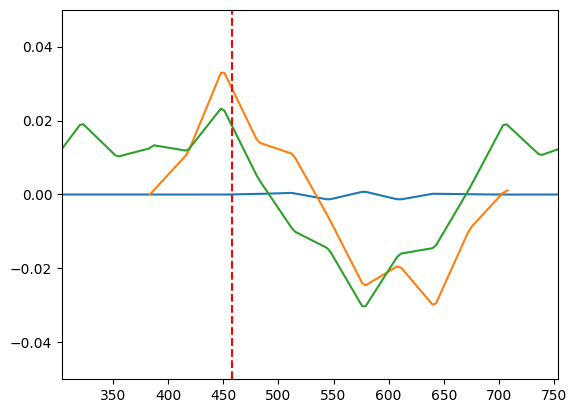

In [43]:
tw_bump = line.twiss(start='mdh.11207', end='mba.12230..0', init=tw)
tw_bump2 = line.twiss()

plt.figure()
plt.plot(tw.s, tw.x)
plt.plot(tw_bump.s, tw_bump.x)
plt.plot(tw_bump2.s, tw_bump2.x)
plt.vlines(s_start_tidp + 4.3, -0.05, 0.05, color='r', linestyle='--')
plt.xlim(s_start_tidp-150, s_start_tidp+300)
plt.ylim(-0.05, 0.05)

In [ ]:
opt = line.match(
    method='6d',
    vary=[
        xt.VaryList(['bump.11207', 'bump.11407', 'bump.11607'], step=1e-8, tag='bump',)
    ],
    targets = [
        xt.Target('x', -30e-3, at='tidp.11434'),
        xt.TargetSet(['x', 'px'], value=tw, at='bph.11608..0')
    ]
    )

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
                                             
Optimize - start penalty: 0.2998                            
Matching: model call n. 16 penalty = 6.7553e-12              
Optimize - end penalty:  6.75526e-12                            


(-0.0015, 0.001)

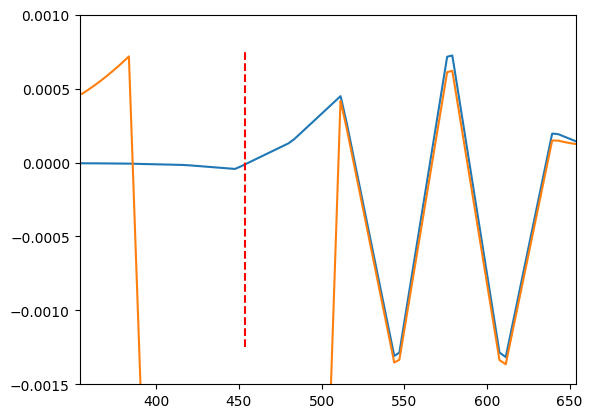

In [122]:
tw2 = line.twiss()
plt.figure()
plt.plot(tw.s, tw.x)
plt.plot(tw2.s, tw2.x)
plt.vlines(s_start_tidp, -0.00125, 0.00075, color='r', linestyle='--')
plt.xlim(s_start_tidp-100, s_start_tidp+200)
plt.ylim(-0.0015,0.001)

In [123]:
line.get_s_position('bph.11608..0')

np.float64(511.5932000000015)

In [106]:
idx_mdh11207 = line.element_names.index('mdh.11207')
idx_mdh11407 = line.element_names.index('mdh.11407')
idx_mdh11607 = line.element_names.index('mdh.11607')
idx_tidp = line.element_names.index('tidp.11434')

opt = line.match(solve=False,
                default_tol={None: 5e-8},
                solver_options=dict(max_rel_penalty_increase=2.),
                init=tw,
                init_at=xt.START,
                start='mba.11190..9',
                end='bph.11608..0',
                #init=tw.get_twiss_init(at_element='mba.11190..9'),
                vary=[
                    xt.VaryList(['bump.11207', 'bump.11407', 'bump.11607'], step=1e-10),
                ],
                targets=[
                    xt.Target('x', at='tidp.11434', value=-30e-3, tol=1e-4),
                    # I want the bump to be closed
                    xt.TargetSet(['x', 'px', 'betx'], value=tw, tol=1e-7, at='mba.11190..9'),
                    xt.TargetSet(['x', 'px', 'betx'], value=tw, tol=1e-7, at='bph.11608..0')
                ]
            )
opt.assert_within_tol=False
opt.restore_if_fail=False


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [107]:
opt.target_status()

Target status:               alty = 2.9975e-01              
id state tag               tol_met       residue   current_val    target_val description                                 
0  ON    tidp.11434_x        False     0.0299755  -2.45122e-05         -0.03 ('x', 'tidp.11434'), val=-0.03, tol=0.00 ...
1  ON    mba.11190..9_x       True             0  -7.10751e-06  -7.10751e-06 ('x', 'mba.11190..9'), val=-7.10751e-06, ...
2  ON    mba.11190..9_px      True             0  -1.04155e-07  -1.04155e-07 ('px', 'mba.11190..9'), val=-1.04155e-07 ...
3  ON    mba.11190..9_betx    True   2.84217e-14       93.7092       93.7092 ('betx', 'mba.11190..9'), val=93.7092, t ...
4  ON    bph.11608..0_x       True  -6.34258e-18   0.000442312   0.000442312 ('x', 'bph.11608..0'), val=0.000442312,  ...
5  ON    bph.11608..0_px      True   -2.1684e-19   -4.2119e-05   -4.2119e-05 ('px', 'bph.11608..0'), val=-4.2119e-05, ...
6  ON    bph.11608..0_betx    True  -1.60466e-08       102.197       102.197 ('betx',

In [108]:
opt.disable_targets([3,6])

In [109]:
opt.solve()

                                             
Optimize - start penalty: 0.2998                            
Matching: model call n. 12 penalty = 1.2981e-07              
Optimize - end penalty:  1.29809e-07                            


In [110]:
opt.target_status()

Target status:               nalty = 1.2981e-07              
id state tag               tol_met       residue   current_val    target_val description                                 
0  ON    tidp.11434_x         True   3.73312e-11         -0.03         -0.03 ('x', 'tidp.11434'), val=-0.03, tol=0.00 ...
1  ON    mba.11190..9_x       True             0  -7.10751e-06  -7.10751e-06 ('x', 'mba.11190..9'), val=-7.10751e-06, ...
2  ON    mba.11190..9_px      True             0  -1.04155e-07  -1.04155e-07 ('px', 'mba.11190..9'), val=-1.04155e-07 ...
3  OFF   mba.11190..9_betx    True   2.84217e-14       93.7092       93.7092 ('betx', 'mba.11190..9'), val=93.7092, t ...
4  ON    bph.11608..0_x       True   1.23923e-08   0.000442324   0.000442312 ('x', 'bph.11608..0'), val=0.000442312,  ...
5  ON    bph.11608..0_px      True   3.86427e-10  -4.21186e-05   -4.2119e-05 ('px', 'bph.11608..0'), val=-4.2119e-05, ...
6  OFF   bph.11608..0_betx   False       4.78829       106.985       102.197 ('betx'

In [118]:
tw.dx

array([7.96227824, 7.96227824, 7.96227824, ..., 7.96227825, 7.96227825,
       7.96227825], shape=(75281,))

In [117]:
# tw2 = line.twiss()
tw2.qx

np.float64(20.12621659018568)